<h3>NLP</h3>

In [18]:
!pip install nltk
!pip install nltk scikit-learn datasets

<module 'nltk' from '/usr/local/lib/python3.11/dist-packages/nltk/__init__.py'>

### Load Trending Dataset (IMDb via 🤗 Datasets)

In [1]:
from datasets import load_dataset

dataset = load_dataset("imdb")
train_data = dataset["train"]
test_data = dataset["test"]


README.md: 0.00B [00:00, ?B/s]

C:\anaconda\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\SAKSHI BADOLA\.cache\huggingface\hub\datasets--imdb. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

## Text Cleaning

In [13]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()# make all lowercase
    text = re.sub(r"<.*?>", "", text)# remove HTML tags
    text = re.sub(r"http\S+", "", text)# remove links
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text) # remove punctuation/special characters
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Prepare Dataset (Clean + Split)

<p> clean_text is applied to each text in training and test sets<br>
Labels are extracted (for example: 1 = positive, 0 = negative)</p>

In [14]:
X_train = [clean_text(x["text"]) for x in train_data]
y_train = [x["label"] for x in train_data]

X_test = [clean_text(x["text"]) for x in test_data]
y_test = [x["label"] for x in test_data]


## Vectorize Text (TF-IDF) Term Frequency-Inverse Document Frequency
<p>
    Converts text into numerical features

Uses TF-IDF, which means:

Words that are frequent in a document but rare in the dataset get more weight

fit_transform → learn vocabulary and convert training data<br>
transform → convert test data using the learned vocabulary
</p>

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=20000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


## Train a Model (Logistic Regression – Best for Sentiment)

In [16]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=2000)
model.fit(X_train_vec, y_train)


LogisticRegression(max_iter=2000)

## Evaluate

In [17]:
from sklearn.metrics import classification_report, accuracy_score

pred = model.predict(X_test_vec)
print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred))


Accuracy: 0.88296
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     12500
           1       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



## Prediction Function

In [23]:
def predict_sentiment(text):
    cleaned = clean_text(text)
    vectorized = vectorizer.transform([cleaned])
    label = model.predict(vectorized)[0]

    return "Positive" if label == 1 else "Negative"

print(predict_sentiment("What a wonderful film!"))


Positive


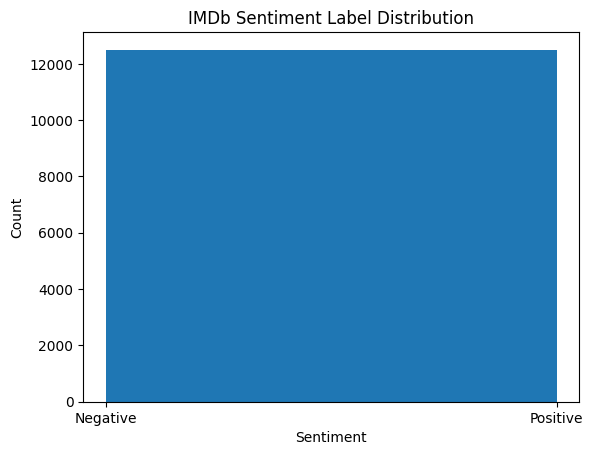

In [10]:
import matplotlib.pyplot as plt
from datasets import load_dataset

# Load IMDb dataset
dataset = load_dataset("imdb")["train"]

labels = [x["label"] for x in dataset]

plt.hist(labels, bins=2)
plt.xticks([0, 1], ["Negative", "Positive"])
plt.title("IMDb Sentiment Label Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


In [11]:
!pip install wordcloud

In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from datasets import load_dataset

dataset = load_dataset("imdb")["train"]

positive_text = " ".join([x["text"] for x in dataset if x["label"] == 1])
negative_text = " ".join([x["text"] for x in dataset if x["label"] == 0])

# Positive
plt.imshow(WordCloud(width=800, height=400).generate(positive_text))
plt.axis("off")
plt.title("Positive Review Word Cloud")
plt.show()

# Negative
plt.imshow(WordCloud(width=800, height=400).generate(negative_text))
plt.axis("off")
plt.title("Negative Review Word Cloud")
plt.show()


wordcloud.wordcloud.WordCloud

In [26]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# -------------------
# 1. Sample Q/A dataset
# -------------------

qa_pairs = {
    "do you have this product in stock": "Yes, it is available right now.",
    "is this item available": "Yes, we have it. If you want, I can check size or color.",
    "when will it be back in stock": "The next restock is expected in 3 to 5 days.",
    "can you notify me when it is available": "Yes, please share your email or phone number.",

    "what is the price": "The price is shown on the product page.",
    "any discount": "We currently have a discount running on selected products.",
    "offers today": "Yes, we have special offers. Please check our deals page.",
    "better price": "I can check if any offers are running on that item.",

    "how long is delivery": "Usually 3 to 7 working days.",
    "deliver to my location": "Yes, we ship across India.",
    "shipping charges": "Shipping is free on orders above ₹499.",
    "track my order": "Yes, you can track using the link sent to your email.",

    "return policy": "You can return any product within 7 days if unused.",
    "how to return": "Go to your order page and click on Return.",
    "when will i get refund": "Refund takes 3 to 5 working days after pickup.",
    "charge for return": "No. Returns are free.",

    "how to place order": "Choose the product, click buy now and select payment method.",
    "payment methods": "Credit card, debit card, UPI, net banking and cash on delivery.",
    "cash on delivery": "Yes, COD is available on most products.",
    "payment failed": "Try again or use another payment method.",

    "will i get bill": "Yes, invoice will be emailed after purchase.",
    "is there warranty": "Many products include warranty. Check product details.",
    "claim warranty": "Contact customer support with invoice and order number.",

    "create account": "Click on Sign Up and fill your details.",
    "forgot password": "Click on Forgot Password to reset.",
    "customer support number": "Yes, support is available. How can I help?",
    "working hours": "Support is available 9 AM to 7 PM.",
}

# Separate questions and answers
questions = list(qa_pairs.keys())
answers = list(qa_pairs.values())


# -------------------
# 2. Clean text function
# -------------------

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    return text


# -------------------
# 3. Vectorize all questions
# -------------------

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([clean_text(q) for q in questions])


# -------------------
# 4. Function to get best answer
# -------------------

def get_response(user_input):
    user_input = clean_text(user_input)
    user_vec = vectorizer.transform([user_input])
    similarity = cosine_similarity(user_vec, X)

    best_match = similarity.argmax()
    score = similarity[0][best_match]

    # If similarity too low → bot doesn't understand
    if score < 0.2:
        return "Sorry, I didn't understand that."

    return answers[best_match]


# -------------------
# 5. Chat Loop
# -------------------

print("Chatbot is ready! Type 'bye' to exit.\n")

while True:
    user = input("You: ")

    if user.lower() in ["bye", "exit", "quit"]:
        print("Bot: Goodbye!")
        break

    reply = get_response(user)
    print("Bot:", reply)


Chatbot is ready! Type 'bye' to exit.



You:  bye


Bot: Goodbye!
